In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import defaultdict

In [3]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.model_selection import cross_validate

In [4]:
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF 
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering

In [5]:
recom = pd.read_csv('ratings_Electronics.csv')

In [6]:
recom.columns=['userId', 'productId', 'Rating', 'timestamp']

In [7]:
recom.head()

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [8]:
recom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userId       object
productId    object
Rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [9]:
print('No. of unique users = ', recom['userId'].nunique())
print('No. of unique items = ', recom['productId'].nunique())

No. of unique users =  4201696
No. of unique items =  476001


Hence, we have 476,001 items being rated by 4,201,696 users an average of 8.8 ratings per user. We will also check the number of ratings per users

Find out the distribution of number of ratings done

In [10]:
a =recom.groupby('userId')['productId'].count()

In [11]:
b=pd.DataFrame(a)

In [12]:
c=b.groupby('productId')['productId'].count()

In [13]:
print('Number of customers with less than 50 ratings: ',c[0:50].sum())
print('Total number of customers:', a.size)

Number of customers with less than 50 ratings:  4200230
Total number of customers: 4201696


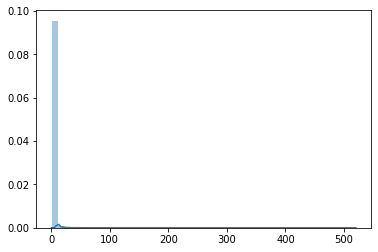

In [14]:
sns.distplot(b)

Almost all users have rated less than 50 products with 35% of them rated only one product. Hence, these may skew our  and hence the same may be dropped to avoid any bias due all these ratings being their first priority

In [15]:
recom.drop('timestamp',axis=1) #dropping timestamp since it is not expected to have too much of an impact on the recommendations provided

,userId,productId,Rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0
5,A3J3BRHTDRFJ2G,0511189877,2.0
6,A2TY0BTJOTENPG,0511189877,5.0
7,A34ATBPOK6HCHY,0511189877,5.0
8,A89DO69P0XZ27,0511189877,5.0
9,AZYNQZ94U6VDB,0511189877,5.0


As per the histogram analysis (for Ratings/ User), dropping all users with less than 50 ratings

In [16]:
recom['Count'] = recom.groupby('userId')['userId'].transform('count')
recom1=recom.loc[recom['Count'] >50]

In [17]:
recom1.size

610855

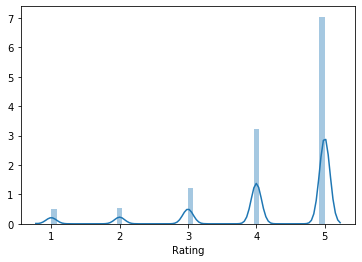

In [18]:
sns.distplot(recom1['Rating'])

Most of the ratings given to various items seem to be a 5 rating. Hence, there is a high probability that the data may be skewed towards people who have enjoyed the items that they have rated rather than provide negative feedback

In [19]:
recom1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122171 entries, 117 to 7824443
Data columns (total 5 columns):
userId       122171 non-null object
productId    122171 non-null object
Rating       122171 non-null float64
timestamp    122171 non-null int64
Count        122171 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.6+ MB


## Collaborative Filtering

In [20]:
reader = Reader(rating_scale=(0, 5))
recom_s = Dataset.load_from_df(recom1[['userId', 'productId', 'Rating']],reader)

In [21]:
trainset, testset = train_test_split(recom_s, test_size=.3)

In [22]:
final_scores=[]

### Deploying KNNwithMeans

#### Base Model

In [23]:
algo_KNNWM_nh = KNNWithMeans()
algo_KNNWM_nh.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [24]:
pred_KNNWM_nh = algo_KNNWM_nh.test(testset)

In [25]:
# get RMSE
print("KNNWithMeans : Test Set")
accuracy_KNNWM_nh = accuracy.rmse(pred_KNNWM_nh, verbose=True)
final_scores.append(('KNNWithMeans',accuracy_KNNWM_nh))

KNNWithMeans : Test Set
RMSE: 1.0561


#### Hyperparameter Tuning

In [26]:
k1=[20, 40, 80, 100, 150]
sim_options=['cosine','pearson','pearson_baseline']
user_based=['True','False']

In [27]:
max_KMMWM_hyper='default'
base_RMS_KMMWM_h=5
# pred_KNNWM_h_final=[]
for i in k1:
    for j in sim_options:
        for l in user_based:
            algo_KNNWM_h = KNNWithMeans(k=i,sim_options={'name': j, 'user_based': l})
            algo_KNNWM_h.fit(trainset)
            pred_KNNWM_h = algo_KNNWM_h.test(testset)
            print("for k = ",i,' and name = ',j, 'and user_based=',l)
            accuracy_KNNWM_h = accuracy.rmse(pred_KNNWM_h, verbose=True)
            if(accuracy_KNNWM_h<=base_RMS_KMMWM_h):
                max_KMMWM_hyper='Optimum model for KNN with hyperparameters: k= '+str(i)+' and name= '+str(j)+' and user_based= '+str(l)
                base_RMS_KMMWM_h=accuracy_KNNWM_h
                pred_KNNWM_h_final=pred_KNNWM_h
print('Final conclusion:')
print(max_KMMWM_hyper, ' and the RMSE score is: ',base_RMS_KMMWM_h)                  
final_scores.append((max_KMMWM_hyper,base_RMS_KMMWM_h))

Computing the cosine similarity matrix...
Done computing similarity matrix.
for k =  20  and name =  cosine and user_based= True
RMSE: 1.0514
Computing the cosine similarity matrix...
Done computing similarity matrix.
for k =  20  and name =  cosine and user_based= False
RMSE: 1.0514
Computing the pearson similarity matrix...
Done computing similarity matrix.
for k =  20  and name =  pearson and user_based= True
RMSE: 1.0427
Computing the pearson similarity matrix...
Done computing similarity matrix.
for k =  20  and name =  pearson and user_based= False
RMSE: 1.0427
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
for k =  20  and name =  pearson_baseline and user_based= True
RMSE: 1.0532
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
for k =  20  and name =  pearson_baseline and user_based= False
RMSE: 1.0532
Computing the cosine similarity matrix.

### Deploying SVD

#### Base model

In [28]:
algo_SVD_nh = SVD()
algo_SVD_nh.fit(trainset)

In [29]:
pred_SVD_nh = algo_SVD_nh.test(testset)

In [30]:
# get RMSE
print("SVD base")
accuracy_SVD_nh = accuracy.rmse(pred_SVD_nh, verbose=True)
final_scores.append(('SVD_base',accuracy_SVD_nh))

SVD base
RMSE: 0.9808


In [31]:
print("RMSE score is:", accuracy_SVD_nh)

RMSE score is: 0.9807761045704335


#### Hyperparameter tuning

In [32]:
n_factors=[50,100,150]
n_epochs=[20,30]
lr_all=[0.005,0.01]
reg_all=[0.02,0.1]
sim_options=['cosine','pearson','pearson_baseline']
user_based=['True','False']

In [33]:
max_SVD_hyper='default'
base_RMS_SVD_h=5
for i in n_factors:
    for j in n_epochs:
        for k in lr_all:
            for l in reg_all:
                algo_SVD_h = SVD(n_factors=i,n_epochs=j,lr_all=k,reg_all=l)
                algo_SVD_h.fit(trainset)
                pred_SVD_h = algo_SVD_h.test(testset)
                print("for n_factors = ",i,' and n_epochs = ',j, 'and lr_all=',k, 'and reg_all =' ,l)
                accuracy_SVD_h = accuracy.rmse(pred_SVD_h, verbose=True)
                if(accuracy_SVD_h<=base_RMS_SVD_h):
                    max_SVD_hyper='Optimum model for SVD with hyperparameters: n_factors= '+str(i)+' and n_epochs= '+str(j)+' and lr_all= '+str(k)+'and reg_all='+str(l)
                    base_RMS_SVD_h=accuracy_SVD_h
                    pred_SVD_h_final=pred_SVD_h
print('Final conclusion:')
print(max_SVD_hyper, ' and the RMSE score is: ',base_RMS_SVD_h)                  
final_scores.append((max_SVD_hyper,base_RMS_SVD_h))

for n_factors =  50  and n_epochs =  20 and lr_all= 0.005 and reg_all = 0.02
RMSE: 0.9780
for n_factors =  50  and n_epochs =  20 and lr_all= 0.005 and reg_all = 0.1
RMSE: 0.9766
for n_factors =  50  and n_epochs =  20 and lr_all= 0.01 and reg_all = 0.02
RMSE: 0.9853
for n_factors =  50  and n_epochs =  20 and lr_all= 0.01 and reg_all = 0.1
RMSE: 0.9766
for n_factors =  50  and n_epochs =  30 and lr_all= 0.005 and reg_all = 0.02
RMSE: 0.9796
for n_factors =  50  and n_epochs =  30 and lr_all= 0.005 and reg_all = 0.1
RMSE: 0.9759
for n_factors =  50  and n_epochs =  30 and lr_all= 0.01 and reg_all = 0.02
RMSE: 0.9920
for n_factors =  50  and n_epochs =  30 and lr_all= 0.01 and reg_all = 0.1
RMSE: 0.9794
for n_factors =  100  and n_epochs =  20 and lr_all= 0.005 and reg_all = 0.02
RMSE: 0.9801
for n_factors =  100  and n_epochs =  20 and lr_all= 0.005 and reg_all = 0.1
RMSE: 0.9772
for n_factors =  100  and n_epochs =  20 and lr_all= 0.01 and reg_all = 0.02
RMSE: 0.9864
for n_factors =  

### Deploying SVDpp

#### Base Model

In [34]:
algo_SVDpp_nh = SVDpp()
algo_SVDpp_nh.fit(trainset)

In [35]:
pred_SVDpp_nh = algo_SVDpp_nh.test(testset)

In [36]:
# get RMSE
print("SVDpp base")
accuracy_SVDpp_nh = accuracy.rmse(pred_SVDpp_nh, verbose=True)
final_scores.append(('SVDpp_base',accuracy_SVDpp_nh))

SVDpp base
RMSE: 0.9828


In [37]:
print("RMSE score is:", accuracy_SVDpp_nh)

RMSE score is: 0.9827691011962835


In [38]:
# #3 fold cross validation across multiple alogrithms researched for this assignment
# benchmark = []
# # Iterate over all algorithms
# for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
#     # Perform cross validation
#     start_time = time.time()
#     results = cross_validate(algorithm, recom_s, measures=['RMSE'], cv=3, verbose=False,n_jobs=1)
#     end_time = time.time()
#     print(algorithm," done")
#     print('Start time: ',start_time)
#     print('End time: ',end_time)
#     print('time taken in seconds: ',end_time-start_time)
#     # Get results & append algorithm name
#     tmp = pd.DataFrame.from_dict(results).mean(axis=0)
#     tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
#     benchmark.append(tmp)
    
# pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

#### Hyperparameter tuning

In [39]:
npp_factors=[50,100,150]
npp_epochs=[20,30]
lrpp_all=[0.005,0.01]
regpp_all=[0.02,0.1]

In [40]:
max_SVDpp_hyper='default'
base_RMS_SVDpp_h=5
for i in npp_factors:
    for j in npp_epochs:
        for k in lrpp_all:
            for l in regpp_all:
                algo_SVDpp_h = SVDpp(n_factors=i,n_epochs=j,lr_all=k,reg_all=l)
                algo_SVDpp_h.fit(trainset)
                pred_SVDpp_h = algo_SVDpp_h.test(testset)
                print("for n_factors = ",i,' and n_epochs = ',j, 'and lr_all=',k, 'and reg_all =' ,l)
                accuracy_SVDpp_h = accuracy.rmse(pred_SVDpp_h, verbose=True)
                if(accuracy_SVDpp_h<=base_RMS_SVDpp_h):
                    max_SVDpp_hyper='Optimum model for SVDpp with hyperparameters: n_factors= '+str(i)+' and n_epochs= '+str(j)+' and lr_all= '+str(k)+'and reg_all='+str(l)
                    base_RMS_SVDpp_h=accuracy_SVDpp_h
                    pred_SVDpp_h_final=pred_SVDpp_h
print('Final conclusion:')
print(max_SVDpp_hyper, ' and the RMSE is: ',base_RMS_SVDpp_h)                  
final_scores.append((max_SVDpp_hyper,base_RMS_SVDpp_h))

for n_factors =  50  and n_epochs =  20 and lr_all= 0.005 and reg_all = 0.02
RMSE: 0.9828
for n_factors =  50  and n_epochs =  20 and lr_all= 0.005 and reg_all = 0.1
RMSE: 0.9781
for n_factors =  50  and n_epochs =  20 and lr_all= 0.01 and reg_all = 0.02
RMSE: 0.9934
for n_factors =  50  and n_epochs =  20 and lr_all= 0.01 and reg_all = 0.1
RMSE: 0.9780
for n_factors =  50  and n_epochs =  30 and lr_all= 0.005 and reg_all = 0.02
RMSE: 0.9891
for n_factors =  50  and n_epochs =  30 and lr_all= 0.005 and reg_all = 0.1
RMSE: 0.9770
for n_factors =  50  and n_epochs =  30 and lr_all= 0.01 and reg_all = 0.02
RMSE: 1.0022
for n_factors =  50  and n_epochs =  30 and lr_all= 0.01 and reg_all = 0.1
RMSE: 0.9830
for n_factors =  100  and n_epochs =  20 and lr_all= 0.005 and reg_all = 0.02
RMSE: 0.9890
for n_factors =  100  and n_epochs =  20 and lr_all= 0.005 and reg_all = 0.1
RMSE: 0.9801
for n_factors =  100  and n_epochs =  20 and lr_all= 0.01 and reg_all = 0.02
RMSE: 0.9956
for n_factors =  

### Deploying Non-negative Matrix Factorization.

#### Base Model

In [41]:
algo_NMF_nh = NMF()
algo_NMF_nh.fit(trainset)

In [42]:
pred_NMF_nh = algo_NMF_nh.test(testset)

In [43]:
print("NMF base")
accuracy_NMF_nh = accuracy.rmse(pred_NMF_nh, verbose=True)
final_scores.append(('NMF_base',accuracy_NMF_nh))

NMF base
RMSE: 1.1402


#### Hyperparameter tuning

In [44]:
nnmf_factors=[50,100,150]
nnmf_epochs=[20,30]
biasmf=[True,False]

In [45]:
max_nmf_hyper='default'
base_RMS_nmf_h=5
for i in nnmf_factors:
    for j in nnmf_epochs:
        for l in biasmf:
            algo_nmf_h = NMF(n_factors=i,n_epochs=j,biased=l)
            algo_nmf_h.fit(trainset)
            pred_nmf_h = algo_nmf_h.test(testset)
            print("for n_factors = ",i,' and n_epochs = ',j, 'and bias =' ,l)
            accuracy_nmf_h = accuracy.rmse(pred_nmf_h, verbose=True)
            if(accuracy_nmf_h<=base_RMS_nmf_h):
                max_nmf_hyper='Model optimized for NMF with hyperparameters: n_factors= '+str(i)+' and n_epochs= '+str(j)+'and bias='+str(l)
                base_RMS_nmf_h=accuracy_nmf_h
                pred_nmf_h_final=pred_nmf_h
print('Final conclusion:')
print(max_nmf_hyper, ' and the RMSE score is: ',base_RMS_nmf_h)                  
final_scores.append((max_nmf_hyper,base_RMS_nmf_h))

for n_factors =  50  and n_epochs =  20 and bias = True
RMSE: 2.2128
for n_factors =  50  and n_epochs =  20 and bias = False
RMSE: 1.2037
for n_factors =  50  and n_epochs =  30 and bias = True
RMSE: 2.0627
for n_factors =  50  and n_epochs =  30 and bias = False
RMSE: 1.1761
for n_factors =  100  and n_epochs =  20 and bias = True
RMSE: 2.7282
for n_factors =  100  and n_epochs =  20 and bias = False
RMSE: 1.2149
for n_factors =  100  and n_epochs =  30 and bias = True
RMSE: 2.9533
for n_factors =  100  and n_epochs =  30 and bias = False
RMSE: 1.2041
for n_factors =  150  and n_epochs =  20 and bias = True
RMSE: 2.4918
for n_factors =  150  and n_epochs =  20 and bias = False
RMSE: 1.2151
for n_factors =  150  and n_epochs =  30 and bias = True
RMSE: 2.4541
for n_factors =  150  and n_epochs =  30 and bias = False
RMSE: 1.2105
Final conclusion:
Model optimized for NMF with hyperparameters: n_factors= 50 and n_epochs= 30and bias=False  and the RMSE score is:  1.1760801441323752


### Deploying SlopeOne

#### Deploying Base Model

In [46]:
algo_SOne_nh = SlopeOne()
algo_SOne_nh.fit(trainset)

In [47]:
pred_SOne_nh = algo_SOne_nh.test(testset)

In [48]:
print("Slope One base")
accuracy_SOne_nh = accuracy.rmse(pred_SOne_nh, verbose=True)
final_scores.append(('SlopeOne_base',accuracy_SOne_nh))

Slope One base
RMSE: 1.0859


### Co-clustering

#### Deploying Base Model

In [49]:
algo_cc_nh=CoClustering()
algo_cc_nh.fit(trainset)

In [50]:
pred_cc_nh = algo_cc_nh.test(testset)

In [51]:
print("Coclustering")
accuracy_cc_nh = accuracy.rmse(pred_cc_nh, verbose=True)
final_scores.append(('CoClustering_base',accuracy_cc_nh))

Coclustering
RMSE: 1.0767


In [52]:
max_cc_hyper='default'
base_RMS_cc_h=5

#### Hyperparameter tuning

In [53]:
n_cltr_u = [5,8,15]
n_cltr_i = [5,7,15]
n_epochs = [40, 80]
for i in n_cltr_u:
    for j in n_cltr_i:
        for k in n_epochs:
            algo_cc_h=CoClustering(n_cltr_u=i,n_cltr_i=j,n_epochs=k)
            algo_cc_h.fit(trainset)
            pred_cc_h = algo_cc_h.test(testset)
            print("for n_cltr_u = ",i,' and n_cltr_i = ',j, 'and n_epochs =' ,k)
            accuracy_cc_h = accuracy.rmse(pred_cc_h, verbose=True)
            if(accuracy_cc_h<=base_RMS_cc_h):
                max_cc_hyper='Model optimized for Co-Clustering with hyperparameters: n_cltr_u= '+str(i)+' and n_cltr_i= '+str(j)+'and n_epochs='+str(k)
                base_RMS_cc_h=accuracy_cc_h
                pred_cc_h_final=pred_cc_h
print('Final conclusion:')
print(max_cc_hyper, ' and the RMSE score is: ',base_RMS_cc_h)                  
final_scores.append((max_cc_hyper,base_RMS_cc_h))

for n_cltr_u =  5  and n_cltr_i =  5 and n_epochs = 40
RMSE: 1.0898
for n_cltr_u =  5  and n_cltr_i =  5 and n_epochs = 80
RMSE: 1.1252
for n_cltr_u =  5  and n_cltr_i =  7 and n_epochs = 40
RMSE: 1.0931
for n_cltr_u =  5  and n_cltr_i =  7 and n_epochs = 80
RMSE: 1.0935
for n_cltr_u =  5  and n_cltr_i =  15 and n_epochs = 40
RMSE: 1.0955
for n_cltr_u =  5  and n_cltr_i =  15 and n_epochs = 80
RMSE: 1.1036
for n_cltr_u =  8  and n_cltr_i =  5 and n_epochs = 40
RMSE: 1.0906
for n_cltr_u =  8  and n_cltr_i =  5 and n_epochs = 80
RMSE: 1.0995
for n_cltr_u =  8  and n_cltr_i =  7 and n_epochs = 40
RMSE: 1.1055
for n_cltr_u =  8  and n_cltr_i =  7 and n_epochs = 80
RMSE: 1.1049
for n_cltr_u =  8  and n_cltr_i =  15 and n_epochs = 40
RMSE: 1.1031
for n_cltr_u =  8  and n_cltr_i =  15 and n_epochs = 80
RMSE: 1.1150
for n_cltr_u =  15  and n_cltr_i =  5 and n_epochs = 40
RMSE: 1.1023
for n_cltr_u =  15  and n_cltr_i =  5 and n_epochs = 80
RMSE: 1.1078
for n_cltr_u =  15  and n_cltr_i =  7 and 

In [54]:
sorted(final_scores,key=lambda l:l[1], reverse=False)

[('Optimum model for SVD with hyperparameters: n_factors= 50 and n_epochs= 30 and lr_all= 0.005and reg_all=0.1',
  0.9758602184943246),
 ('Optimum model for SVDpp with hyperparameters: n_factors= 50 and n_epochs= 30 and lr_all= 0.005and reg_all=0.1',
  0.9770101841090814),
 ('SVD_base', 0.9807761045704335),
 ('SVDpp_base', 0.9827691011962835),
 ('Optimum model for KNN with hyperparameters: k= 150 and name= pearson and user_based= False',
  1.042658728693948),
 ('KNNWithMeans', 1.0561443068767216),
 ('CoClustering_base', 1.07671174842614),
 ('SlopeOne_base', 1.085877341659451),
 ('Model optimized for Co-Clustering with hyperparameters: n_cltr_u= 5 and n_cltr_i= 5and n_epochs=40',
  1.089796905140123),
 ('NMF_base', 1.1401747030947285),
 ('Model optimized for NMF with hyperparameters: n_factors= 50 and n_epochs= 30and bias=False',
  1.1760801441323752)]

Almost all the algorithms have given us a RMSE within a range of 0.977 to 1.17 scores. However, going for the lowest RMSE, we will go ahead and obtain top n recommendations using SVD with hyperparameters: n_factors= 50 and n_epochs= 30 and lr_all= 0.005and reg_all=0.1

## Popularity Recommender 

In [55]:
recom2=recom1.copy()
from sklearn.model_selection import train_test_split
train_pop, test_pop = train_test_split(recom2,test_size=0.30, random_state=3)

In [56]:
ratings_total = pd.DataFrame(train_pop.groupby('productId')['Rating'].sum())
ratings_total['Rating_count'] = pd.DataFrame(train_pop.groupby('productId')['Rating'].count())
ratings_total['Average']= pd.DataFrame(train_pop.groupby('productId')['Rating'].mean())
ratings_total.head()

,Rating,Rating_count,Average
productId,,,
0970407998,5.0,2,2.5
0972683275,5.0,1,5.0
1400501466,9.0,3,3.0
1400501520,5.0,1,5.0
1400501776,9.0,2,4.5


In [57]:
ratings_total['Rating'].sort_values(ascending=False).head()

productId
B0088CJT4U    626.0
B003ES5ZUU    572.0
B000N99BBC    556.0
B007WTAJTO    539.0
B00829TIEK    414.0
Name: Rating, dtype: float64

In [58]:
ratings_total.reset_index(level=0, inplace=True)
ratings_total['Position'] = ratings_total.index+1

In [59]:
ratings_total

,productId,Rating,Rating_count,Average,Position
0,0970407998,5.0,2,2.500000,1
1,0972683275,5.0,1,5.000000,2
2,1400501466,9.0,3,3.000000,3
3,1400501520,5.0,1,5.000000,4
4,1400501776,9.0,2,4.500000,5
5,1400532655,5.0,2,2.500000,6
6,140053271X,1.0,1,1.000000,7
7,1400599997,10.0,3,3.333333,8
8,1400698987,9.0,2,4.500000,9
9,1400699169,5.0,1,5.000000,10


In [60]:
ratings_total_test = pd.DataFrame(test_pop.groupby('productId')['Rating'].sum())
ratings_total_test['Rating_count'] = pd.DataFrame(test_pop.groupby('productId')['Rating'].count())
ratings_total_test['Average']= pd.DataFrame(test_pop.groupby('productId')['Rating'].mean())
ratings_total_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20848 entries, 0594481813 to B00LED02VY
Data columns (total 3 columns):
Rating          20848 non-null float64
Rating_count    20848 non-null int64
Average         20848 non-null float64
dtypes: float64(2), int64(1)
memory usage: 651.5+ KB


In [61]:
ratings_total_test['Rating'].sort_values(ascending=False).head()

productId
B003ES5ZUU    288.0
B0088CJT4U    234.0
B00829TIEK    233.0
B000N99BBC    222.0
B007WTAJTO    193.0
Name: Rating, dtype: float64

In [62]:
ratings_total_test

,Rating,Rating_count,Average
productId,,,
0594481813,3.0,1,3.000000
0972683275,10.0,2,5.000000
1400501466,6.0,2,3.000000
1400532620,6.0,2,3.000000
1400532655,13.0,3,4.333333
140053271X,4.0,1,4.000000
1400599997,5.0,1,5.000000
3744295508,5.0,1,5.000000
787988002X,5.0,1,5.000000


In [63]:
ratings_total_test.reset_index(level=0, inplace=True)
ratings_total_test['Position'] = ratings_total_test.index+1

In [64]:
Final_compare = pd.merge(ratings_total, ratings_total_test, on='productId')
Final_compare.head()

,productId,Rating_x,Rating_count_x,Average_x,Position_x,Rating_y,Rating_count_y,Average_y,Position_y
0,0972683275,5.0,1,5.000000,2,10.0,2,5.000000,2
1,1400501466,9.0,3,3.000000,3,6.0,2,3.000000,3
2,1400532655,5.0,2,2.500000,6,13.0,3,4.333333,5
3,140053271X,1.0,1,1.000000,7,4.0,1,4.000000,6
4,1400599997,10.0,3,3.333333,8,5.0,1,5.000000,7


#### A.  Calculating the RMSE based on the mean rating of each Product

In [65]:
from sklearn.metrics import mean_squared_error

In [66]:
rmse_mean_rating = np.sqrt( mean_squared_error(Final_compare['Average_x'], Final_compare['Average_y'] ) )
print("RMSE for mean rating is:", rmse_mean_rating)

RMSE for mean rating is: 1.0927492138771269


#### B. Calculating the RMSE based on the mean position of each Product

In [67]:
rmse_mean_pos = np.sqrt( mean_squared_error(Final_compare['Position_x'], Final_compare['Position_y'] ) )
print("RMSE for mean position in the recommendation list is:", rmse_mean_pos,' on a data size of: ', Final_compare.size)

RMSE for mean position in the recommendation list is: 10170.692448837937  on a data size of:  100404


#### C. Detailed exercise on Product Position assessment

In [68]:
# This analysis will be done as follows:
# 1. For each user, sort the ratings and identify the position of each objectid in that sorted dataframe
# 2. Find the average position of the object and compare it to the Popular Recommendation Model used

In [69]:
ratings_total.count()

productId       37463
Rating          37463
Rating_count    37463
Average         37463
Position        37463
dtype: int64

In [70]:
ratings_total_test.count()

productId       20848
Rating          20848
Rating_count    20848
Average         20848
Position        20848
dtype: int64

In [71]:
test_pop.head()

,userId,productId,Rating,timestamp,Count
3654449,A2KYRPDKVBI2R4,B003XIJ3MW,5.0,1361923200,157
7821008,A1ODOGXEYECQQ8,B00KCAPAKI,4.0,1401753600,380
102247,A324X7RVDAV3FT,B00005LEN4,4.0,1305504000,56
436822,A18HE80910BTZI,B00026WRFI,4.0,1099526400,177
6428308,A2NSMJVQY0RV9S,B00908A8PK,4.0,1389484800,91


In [72]:
test_pop.loc[test_pop['userId']=='A2KYRPDKVBI2R4'].head()

,userId,productId,Rating,timestamp,Count
3654449,A2KYRPDKVBI2R4,B003XIJ3MW,5.0,1361923200,157
7701057,A2KYRPDKVBI2R4,B00GJFGDUQ,5.0,1397001600,157
4398695,A2KYRPDKVBI2R4,B004RKQM8I,4.0,1373414400,157
3892000,A2KYRPDKVBI2R4,B0045JNA18,5.0,1361923200,157
172425,A2KYRPDKVBI2R4,B00006B82N,5.0,1361923200,157


In [73]:
final_stack=pd.DataFrame()

In [74]:
check=[]
for user in test_pop['userId']:
    if user in check:
        continue
    else:
        check.append(user)
        user_list=[]
        user_list=test_pop.loc[test_pop['userId']==user].copy()
        user_list.sort_values(by='Rating', ascending=False, inplace=True)
        user_list.reset_index(level=0, inplace=True)
        user_list['Position'] = user_list.index+1
        final_stack=pd.concat([final_stack, user_list], ignore_index=True)
print(final_stack)

         index          userId   productId  Rating   timestamp  Count  \
0      3654449  A2KYRPDKVBI2R4  B003XIJ3MW     5.0  1361923200    157   
1      7701057  A2KYRPDKVBI2R4  B00GJFGDUQ     5.0  1397001600    157   
2       525372  A2KYRPDKVBI2R4  B0002ZPJZY     5.0  1360886400    157   
3      7242665  A2KYRPDKVBI2R4  B00CD778LC     5.0  1384905600    157   
4      6699472  A2KYRPDKVBI2R4  B009RQYBNU     5.0  1360886400    157   
5      4641756  A2KYRPDKVBI2R4  B0051XE9PS     5.0  1361923200    157   
6      3935938  A2KYRPDKVBI2R4  B0047T7PTO     5.0  1361923200    157   
7      5954183  A2KYRPDKVBI2R4  B007WTAJTO     5.0  1367193600    157   
8      3942340  A2KYRPDKVBI2R4  B00483WRZ6     5.0  1367193600    157   
9      5017712  A2KYRPDKVBI2R4  B005J4C820     5.0  1363219200    157   
10      499053  A2KYRPDKVBI2R4  B0002OF2FC     5.0  1361923200    157   
11     7328820  A2KYRPDKVBI2R4  B00CXP5R6M     5.0  1380240000    157   
12     3693732  A2KYRPDKVBI2R4  B003YV64OI     5.0 

In [75]:
final_stack.head()

,index,userId,productId,Rating,timestamp,Count,Position
0,3654449,A2KYRPDKVBI2R4,B003XIJ3MW,5.0,1361923200,157,1
1,7701057,A2KYRPDKVBI2R4,B00GJFGDUQ,5.0,1397001600,157,2
2,525372,A2KYRPDKVBI2R4,B0002ZPJZY,5.0,1360886400,157,3
3,7242665,A2KYRPDKVBI2R4,B00CD778LC,5.0,1384905600,157,4
4,6699472,A2KYRPDKVBI2R4,B009RQYBNU,5.0,1360886400,157,5


In [76]:
ratings_final_pos_test = pd.DataFrame(final_stack.groupby('productId')['Position'].mean())

In [77]:
Final_compare2 = pd.merge(ratings_total, ratings_final_pos_test, on='productId')
Final_compare2.size

66936

In [78]:
rmse_mean_pos = np.sqrt( mean_squared_error(Final_compare2['Position_x'], Final_compare2['Position_y'] ) )
print("RMSE for mean position in the recommendation list is:", rmse_mean_pos)

RMSE for mean position in the recommendation list is: 22513.181047509726


The RMSE for approach (C) across 66,936 positions is 22513 if we consider the mean average position of each item on each user's recommendation list. On a RMSE per item ratio, this value is 0.33. <br>
However, if we take the same ratio for the optimized collaborative filtering model, this comes to 0.977 /5 (max rating) which is around 0.195<br>
Further, if we only consider the average rating for the popularity model, (Approach (A)) the RMSE is 1.1 against 0.977. This could also be because the test and train data could contain data of the same user

## Get top - K ( K = 5) recommendations

### Defining function for top 5 recommendations

In [79]:
def get_top_5(predicts):
    #Mapping predictions to each user
    top_5 = defaultdict(list)
    for uid, iid, true_r, est, _ in predicts:
        top_5[uid].append((iid, est))

    #Sorting all predictions and getting the top 5
    for uid, user_ratings in top_5.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_5[uid] = user_ratings[:5]

    return top_5


In [80]:
top_5 = get_top_5(pred_SVD_h_final)

In [81]:
for uid, user_ratings in top_5.items():
    print(uid, [iid for (iid, _) in user_ratings])

AT6CZDCP4TRGA ['B0000511U7', 'B009NB8WR0', 'B003DZJQQI', 'B005T3GPXO', 'B003ES5ZUU']
ATZJNEXX7LWD3 ['B001TH7GT6', 'B003ZUM5LE', 'B002MAPSQM', 'B005O88CY4', 'B004N625BO']
A2LB4FLRZG6CUV ['B005OA3BSY', 'B00ENZRS76', 'B000EVSLRO', 'B001MSVPM6', 'B0096T97OG']
A1BVE2ZIBKJ7YI ['B00889ST2G', 'B002C7481G', 'B00AXTQQDS', 'B005HQ50SO', 'B0067XVNTG']
A16HXVNPU5TCGE ['B003LVZO92', 'B003ANK9ZA', 'B00009R6UU', 'B00BU91JD2', 'B00DZYEXPQ']
A6VXZ1EEPRTLV ['B000NP3DJW', 'B000HPV3RW', 'B0082E9K7U', 'B00DK2JQOQ', 'B003TXRTNG']
ARTA78TP6H73D ['B009X01C64', 'B003PL0AME', 'B00FRKOFIQ', 'B00825BZUY', 'B00JST4VHW']
A2QRXQPHDMFCQV ['B000MF4N42', 'B008O2HWTI', 'B0035JJOLE', 'B002LAS1DU', 'B000QGBC8C']
A1JZFGZEZVWQPY ['B00A4ZXE40', 'B000X1TS54', 'B00119T6NQ', 'B0003NN83U', 'B0006LSINO']
A11I1I9QLMAM1A ['B00D5Q75RC', 'B009NHWVIA', 'B005KFONIU', 'B00BOHNYU6', 'B003VAHYNC']
A2ZRMCRLDSUX6R ['B001U0OGQS', 'B000067RT6', 'B00829TIA4', 'B00IF4OATU', 'B005GOINEK']
A3F9CMU8KNAY1M ['B001TH7GSW', 'B002HWRJY4', 'B001GIPSA2', 

A1T1YSCDW0PD25 ['B001F51G16', 'B001C271MA', 'B0099SMFVQ', 'B005UA3I72', 'B009USAJCC']
A3UR2N0ATGBCU8 ['B00471EYUU', 'B005DKZTMG', 'B00CXACPN0', 'B009HP42HQ', 'B002NVC1DS']
AVJORH3ACR2A5 ['B001342KM8', 'B000MX48VM', 'B00834SJNA', 'B0083J8D90', 'B004EHSV4W']
A2KOV8XWZOZ0FQ ['B001IEZX3G', 'B0099SMFVQ', 'B001TH7T2U', 'B001TH7GVE', 'B002TLTE6O']
A11ED8O95W2103 ['B00006HSYC', 'B0000228GG', 'B000065BPC', 'B00000J3G3', 'B000EMWBV0']
A23QII83UGZP5U ['B0036V9AGU', 'B00AQUO5RI', 'B00829THEG', 'B00IUICOHG', 'B008RVJJZG']
A1YVO5V1SO18DZ ['B00CD8ADKO', 'B009NHWVIA', 'B00F1CRTLK', 'B00F1CRTJM', 'B00BM1PWY0']
A2XXBZPQT5EXHV ['B000BQ7GW8', 'B00JF0D7RE', 'B001MX5YWI', 'B006W8U2MU', 'B001TH7GSW']
A3LDLV1GWQJLEQ ['B00F19Q7AC', 'B007PTCFFW', 'B00CO1I29O', 'B004R929AY', 'B000EOPQ7E']
A11T807LX2EF00 ['B00BOHNYU6', 'B0025VKUPW', 'B009SYZ8OC', 'B002YOENAS', 'B00829TIEK']
A4H4KYSM2KQ85 ['B002V8C3W2', 'B000H4CLXS', 'B008OEHPKM', 'B008MWBY6W', 'B002JCSV8A']
AV8MDYLHHTUOY ['B007PTCFFW', 'B009SYZ8OC', 'B00829TIA4',

AD0J5KK4WQXNS ['B0009K9FZW', 'B00006B9H8', 'B000LRMR26', 'B0009GZSSO', 'B0002ED4PM']
ATOKT8QYK967L ['B004GF8TIK', 'B003FVVMS0', 'B00511PS3C', 'B007AMSSXM', 'B00DQZSFSA']
AIBRTGBN07D6A ['B000N99BBC', 'B00DJ6AGBU', 'B0002WPREU', 'B005QBK5V2', 'B0011FQURK']
AYCAIHABPYWVJ ['B001TUYTZM', 'B00139VKU6', 'B004FHO5Y6', 'B003YTROIU', 'B008YKV5RA']
A34C9AFFZOI45T ['B000HPV3RW', 'B005ARQV6U', 'B005TX3M62', 'B003WV5DJC', 'B00080G0BK']
AZAC8O310IK4E ['B000HPV3RW', 'B002Y6CJJ8', 'B001F7AHXM', 'B00AQUO5RI', 'B000LRMS66']
A2CIQEY05SPHTZ ['B002LEVGMO', 'B001QTXL82', 'B00972M942', 'B00FF9FFX8', 'B004GKLW70']
A1PL7QILVQV3IF ['B000JE7GPY', 'B0013AV4M4', 'B0012X5766', 'B0055MBQOW', 'B000JO1IPI']
A124WZCUIH2T7W ['B003LVZO8S', 'B00391XGDA', 'B0002YE6FY', 'B003Y35VJA', 'B003GMNPEC']
A2ZY3S7SD3QO8Z ['B0094S35W4', 'B0035FZ13I', 'B00829TIEK', 'B004QOA92A', 'B00006JLOS']
A33CNFK776MTWR ['B000AY5Y5W', 'B00E9YIFKA', 'B005DKIID8', 'B00AJG3NK4', 'B004W2JKWG']
A38RMU1Y5TDP9 ['B009WZRBPQ', 'B0067WUSGQ', 'B006FNCWSY', 'B

A19X4BF861LQST ['B000BQ7GW8', 'B005ZT5C2M', 'B000MX48VM', 'B000R3BTDC', 'B00009R6JT']
A110PC8C5Y7MQD ['B001UI2FPE', 'B005EOWBKE', 'B005NGQWL2', 'B0001656FW', 'B000V0ETA6']
A2T689YVOAYGGD ['B000ENUCR4', 'B00DXFDHV8', 'B0034CL2ZI', 'B003MVZ60S', 'B002QEBMAK']
A1SDPA1J98UP4L ['B00029U1DK', 'B00B588HY2', 'B00081A2KY', 'B00004SB92', 'B002MCZJ78']
A3J3ZHGDUDPCFL ['B000N99BBC', 'B00IF4OATU', 'B00D695GS8', 'B001NJ0WCS', 'B00F69PXL6']
A2J8T58Z4X15IO ['B008EQZ25K', 'B008C1JC4O', 'B009LL9VDG', 'B000UXZUZC', 'B00D429Y12']
A2HPJKM7L4EOQB ['B000EMWBV0', 'B00005Y1S2', 'B00005UKBD', 'B0006VSHE4', 'B0001G6UB6']
A3OZA8HNJM26DC ['B001TUYTZM', 'B006T9B6R2', 'B004TPPWT6', 'B007Y0EQE0', 'B007HSKSMI']
ATFBVUXDIRXT6 ['B0019EHU8G', 'B007R5YDYA', 'B00DT04I9W', 'B003SQEAY0', 'B00F0DD0I6']
A3D1TZH619NKHN ['B00DSGLM50', 'B004CLYEDC', 'B000Q82PIQ', 'B001TOD7ME', 'B002TLSOG0']
A2SZLNSI5KOQJT ['B000IJY8DS', 'B00DLKE7OQ', 'B004CLYE8C', 'B000WYVBR0', 'B003FGF2MC']
AY3D7DG5L5WCK ['B0058FAYPI', 'B0061HMRA2', 'B008X9Z3UC'

<b>Final Conclusion</b><br>
The popularity model is a good model for cold start problems since while not as accurate as the Collaborative Filtering model, is not wholly inaccurate <br>
Unfortunately, the data is heavily skewed due to the low number of ratings by individual users. However, as this data set increases and more users are encouraged to keep rating products, that bias should gradually move out <br>
Recommender systems are significantly more informative as compared to the popularity model. More specifically, the accuracy of the model will actually increase far more than a similar accuracy in the popular model due to the same being mapped not just at the rating level but the user and the productId level as well<br>
For the data provided, the SVD model with the given hyperparameters had the least error in recommending products based on the test set. This helped us arrive at the Top 5 recommendations for each user in the test set. 
However, in the real world, we would need to go beyond just the RMSE and look at parameters in the live environment such as hit rate for top N recommendations, Coverage, Diversity and Novelty parameters <br>
